**Introduction**

Intracranial hemorrhage, bleeding that occurs inside the cranium, is a serious health problem that requires rapid and often intensive medical treatment. Intracranial hemorrhages account for approximately 10% of strokes in the U.S., where stroke is the fifth-leading cause of death. Identifying the location and type of any hemorrhage present is a critical step in treating the patient.
Diagnosis requires an urgent procedure. When a patient shows acute neurological symptoms such as severe headache or loss of consciousness, highly trained specialists review medical images of the patient’s cranium to look for the presence, location and type of hemorrhage. The process is complicated and often time consuming.

For this caspstone, I am using using RSNA intracranial hemorrhage detection data set from Kaggle, (https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/overview/description) in order to identify acute intracranial hemorrhage and its subtypes from the CT study images of patients. The CT images can confirm bleeding and the evidence of trauma in head. Correct diagnosis of presence of hemorrhage and its type looking at the radiological report of the patient helps timely and effective care. The dataset consists of CT studies of patients and the probability of whether the type of hemorrhage exists or not. 


My objective is to build an algorithm that can detect hemorrhage and its type which could be a valuable information for the medical community to make data driven decisions. 


In [68]:
#Importing the required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pydicom

from os import listdir

from skimage.transform import resize
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.applications import ResNet50
import cv2

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, SGD
from keras import layers
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from tqdm import tqdm
import os

In [69]:
listdir("../input/rsna-intracranial-hemorrhage-detection/")

['stage_1_test_images',
 'stage_1_train.csv',
 'stage_1_sample_submission.csv',
 'stage_1_train_images']

In [70]:
INPUT_PATH = "../input/rsna-intracranial-hemorrhage-detection/"

**Importing CSVs and Images**

The data consists of CT images as stage-1_train.zpi and stage-1_test.zip and data  for train and test. The dataset also consists of IDs of the patients as (stage_1_train.csv ) (stage_1_sample_submission.csv) and multiple labels, one for each of five sub-types of hemorrhage, plus an additional label for any, which should always be true if any of the sub-type labels is true.

I used a Kaggle kernel to avoid  donwloading this big dataset set to my local machine. Further I am using only the stage_1_train images and stage_1_train.csv  data which includes patient information of the respective images. I have splitted the training data further into train and evaluation sets.


In [71]:
traindf = pd.read_csv(INPUT_PATH + "stage_1_train.csv")
traindf.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [72]:
traindf['type'] = traindf['ID'].str.split("_", n = 3, expand = True)[2]
traindf['PatientID'] = traindf['ID'].str.split("_", n = 3, expand = True)[1]
traindf['filename'] = traindf['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
traindf.head()

,ID,Label,type,PatientID,filename
0,ID_63eb1e259_epidural,0,epidural,63eb1e259,ID_63eb1e259.png
1,ID_63eb1e259_intraparenchymal,0,intraparenchymal,63eb1e259,ID_63eb1e259.png
2,ID_63eb1e259_intraventricular,0,intraventricular,63eb1e259,ID_63eb1e259.png
3,ID_63eb1e259_subarachnoid,0,subarachnoid,63eb1e259,ID_63eb1e259.png
4,ID_63eb1e259_subdural,0,subdural,63eb1e259,ID_63eb1e259.png


In [73]:
traindf.filename.nunique()


674258

Let us see if the filename matches the number of images

In [74]:
train_directory = INPUT_PATH + "stage_1_train_images/"
train_files = listdir(train_directory)

train_size = len(train_files)
train_size

674258

We can see that the number of filenames matches the number of images in the image directory

**Data Visualization**

Let us plot a digram to visualize the distribution of label in the dataset and also see the distribution by type of hemorrhage

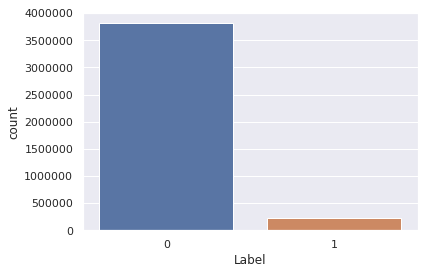

In [75]:
traindf['Label'].value_counts()
sns.countplot(x= 'Label', data = traindf);

We can see the data imbalance here (The images with hemorrhage being less). We will try balancing before building our model

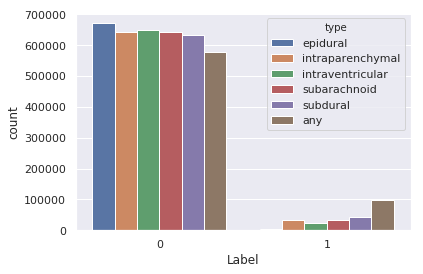

In [76]:
traindf['Label'].value_counts()
sns.countplot(x= 'Label', data = traindf, hue = 'type');

**Preprocessing the images**

Rescaling resizing and converting the .dcm imgaes to .png

In [77]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]


def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        data = pydicom.read_file(os.path.join(INPUT_PATH + "stage_1_train_images/",'ID_'+images[im]+ '.dcm'))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
    plt.suptitle(title)
    plt.show()

In [78]:
def save_and_resize(filenames, load_dir):   
    X=[] 
    
    save_dir = '/kaggle/tmp/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for filename in tqdm(filenames):
        path = load_dir + filename
        new_path = save_dir + filename.replace( '.dcm', '.png' )
        
        dcm = pydicom.dcmread(path)
        window_center , window_width, intercept, slope = get_windowing(dcm)
        img = dcm.pixel_array
        img = window_image(img, window_center, window_width, intercept, slope)
        
        resized = cv2.resize(img, (224, 224)) 
        res = cv2.imwrite(new_path, resized)
        if not res:
            print('Failed')

**Visualization of images**

In [79]:
train_files[0:5]

['ID_ff816e9b6.dcm',
 'ID_282a7f3cd.dcm',
 'ID_f1c65b76e.dcm',
 'ID_3b59681d3.dcm',
 'ID_f506d79aa.dcm']

In [80]:
#Lets see what the images contain
dataset = pydicom.dcmread(train_directory + "ID_3b59681d3.dcm")
print(dataset)

(0008, 0018) SOP Instance UID                    UI: ID_3b59681d3
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_174f992b'
(0020, 000d) Study Instance UID                  UI: ID_31f18d004c
(0020, 000e) Series Instance UID                 UI: ID_def4bb5674
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000000', '-95.561577', '145.102463']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.939693', '-0.342020']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored 

In [81]:
subtypes = traindf.type.unique()
subtypes

array(['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid',
       'subdural', 'any'], dtype=object)

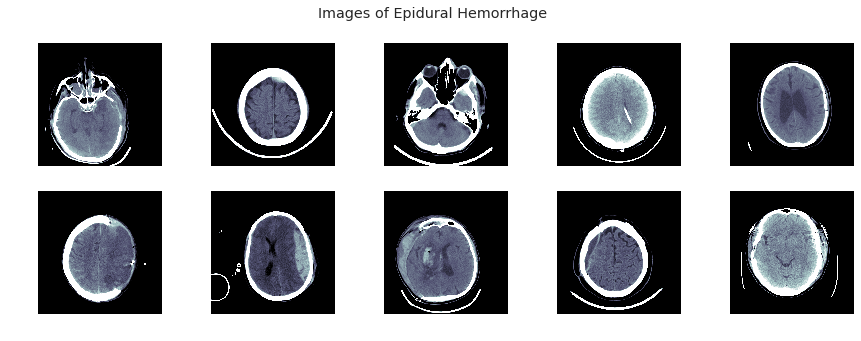

In [82]:
view_images(traindf[(traindf['type'] == 'epidural') & (traindf['Label'] == 1)][:10].PatientID.values, title = 'Images of Epidural Hemorrhage')

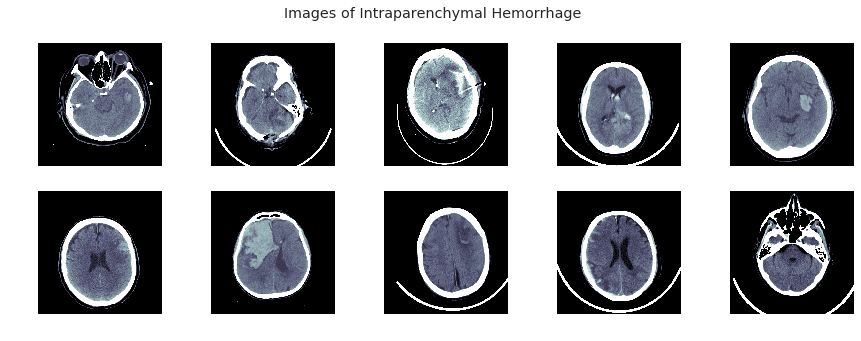

In [83]:
view_images(traindf[(traindf['type'] == 'intraparenchymal') & (traindf['Label'] == 1)][:10].PatientID.values, title = 'Images of Intraparenchymal Hemorrhage')

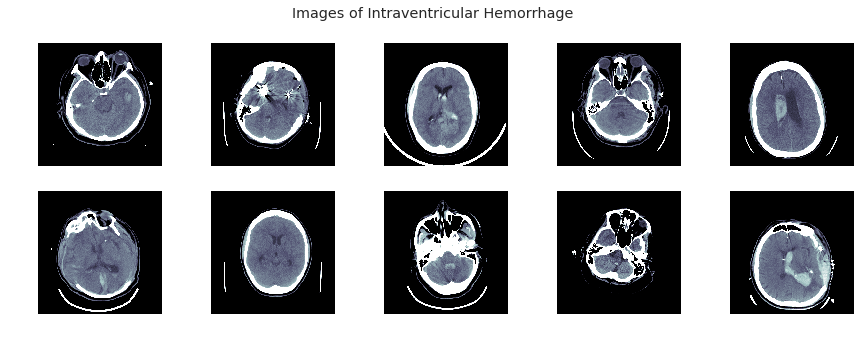

In [84]:
view_images(traindf[(traindf['type'] == 'intraventricular') & (traindf['Label'] == 1)][:10].PatientID.values, title = 'Images of Intraventricular Hemorrhage')

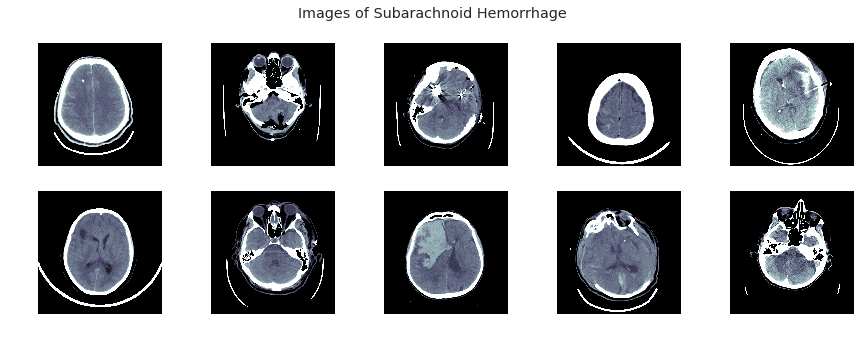

In [85]:
view_images(traindf[(traindf['type'] == 'subarachnoid') & (traindf['Label'] == 1)][:10].PatientID.values, title = 'Images of Subarachnoid Hemorrhage')

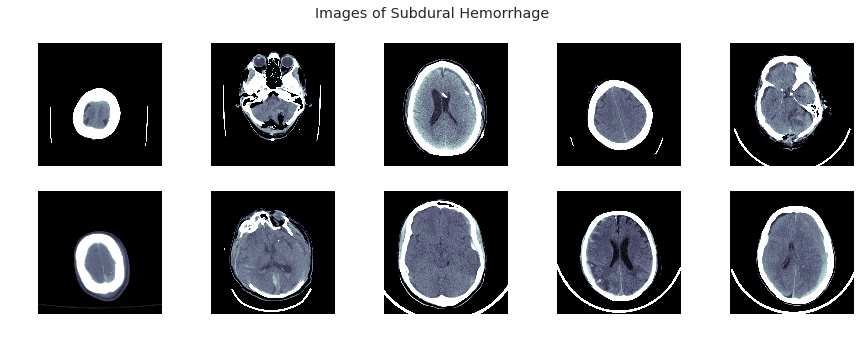

In [86]:
view_images(traindf[(traindf['type'] == 'subdural') & (traindf['Label'] == 1)][:10].PatientID.values, title = 'Images of Subdural Hemorrhage')

**Preparing the dataframe
**



In [87]:
traindf.head(2)

,ID,Label,type,PatientID,filename
0,ID_63eb1e259_epidural,0,epidural,63eb1e259,ID_63eb1e259.png
1,ID_63eb1e259_intraparenchymal,0,intraparenchymal,63eb1e259,ID_63eb1e259.png


We are taking random sample of 1000 images. This is only for faster run time, with more CPU, GPU we can use all images. 

In [88]:
np.random.seed(0)
sample_data = np.random.choice((train_files), 1000)  
sample_df = traindf[traindf.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_data)]

pivot_df = sample_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(pivot_df.shape)
pivot_df.head(2)

(999, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_001b52ebc.png,0,0,0,0,0,0
1,ID_00a2e95dd.png,0,0,0,0,0,0


In [89]:
import os
save_and_resize(filenames=sample_data, load_dir=INPUT_PATH + "stage_1_train_images/")

100%|██████████| 1000/1000 [00:04<00:00, 212.13it/s]


Reading each of the 1000 images with opencv and saving as matrix 

In [90]:
X=[]
y=[] 
path =  '/kaggle/tmp/' 
import cv2  
import glob 

for i, row in pivot_df.iterrows():  
    file = row['filename'] 
    if path+ file in glob.glob('/kaggle/tmp/*.png') : 
        img=path+file
        img=cv2.imread(img, 0) #grey 
        #print(img.shape)
        X.append(img)
        y.append(row['any'])  
    else: 
        continue

In [91]:
X= np.array(X)
y= np.array(y)

In [92]:
X.shape, y.shape

((999, 224, 224), (999,))

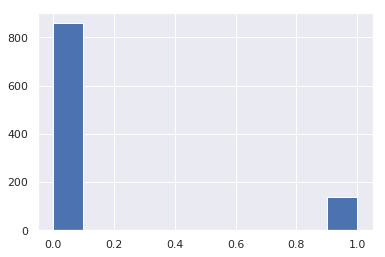

In [93]:
plt.hist(y);

We can see the data is imbalanced. We will balance the data by undersampling the majority class (this is to save the omputational time as well due to the limitation of CPU/GPU)

Let us split the data to train and test sets

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(749, 224, 224)
(250, 224, 224)
(749,)
(250,)


Balancing the data by undersample the majority class

In [95]:
#Oversample
#from imblearn.over_sampling import SMOTE
#Let us upsample the dataset
#oversampler= SMOTE(random_state=0)
#X_train_final, y_train_final = oversampler.fit_sample(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

In [96]:
# print(X_train_final.shape)
# print(y_train_final.shape)

In [97]:
#Undersample
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_train_final, y_train_final = rus.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

In [98]:
X_train_final.shape, y_train_final.shape

((208, 50176), (208,))

Normalizing the pixel values between 0 and 1

In [99]:
X_train= X_train_final.reshape(X_train_final.shape[0], 224, 224)/255
y_train = y_train_final 
X_test = X_test/255
y_test = y_test

In [100]:
X_train= X_train/255
y_train = y_train
X_test = X_test/255
y_test = y_test

In [104]:
img_rows, img_cols = 224, 224
X_train = X_train.reshape((-1, img_rows, img_cols, 1))
y_train = y_train
X_test = X_test.reshape((-1, img_rows, img_cols, 1))

In [105]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((208, 224, 224, 1), (208,), (250, 224, 224, 1), (250,))

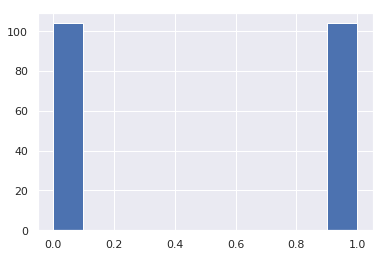

In [106]:
plt.hist(y_train);

We can see the balanced train data set

0


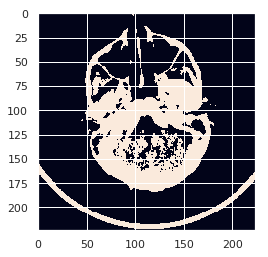

In [107]:
plt.imshow(X_train[1].reshape(224, 224)) 
print(y_train[1])

**Building Models**

Dense model

In [108]:
from keras.layers import Add
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 


 
    
# class_weight = {0: 10,
#                 1: 1 } 

model_dense = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model_dense.add(Dense(32, activation='relu', input_shape=(224, 224,1)))
# Dropout layers remove features and fight overfitting
model_dense.add(Dropout(0.4))
model_dense.add(Dense(32, activation='relu'))
model_dense.add(Dropout(0.4))
# End with a number of units equal to the number of classes we have for our outcome
model_dense.add(Flatten())
model_dense.add(Dense(1, activation='softmax'))


model_dense.summary()


# Compile the model to put it all together.
model_dense.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_dense = model_dense.fit(X_train, y_train,
                          batch_size=64,
                          epochs=3,
                          verbose=1,
                          validation_data=(X_test, y_test))
score = model_dense.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 224, 224, 32)      64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 224, 224, 32)      0         
_________________________________________________________________
dense_10 (Dense)             (None, 224, 224, 32)      1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 224, 224, 32)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1605632)           0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1605633   
Total params: 1,606,753
Trainable params: 1,606,753
Non-trainable params: 0
____________________________________________

In [109]:
y_pred= model_dense.predict(X_test)

In [110]:
#Model Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred)) 

[[  0 214]
 [  0  36]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       214
           1       0.14      1.00      0.25        36

    accuracy                           0.14       250
   macro avg       0.07      0.50      0.13       250
weighted avg       0.02      0.14      0.04       250



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Convolutional Neural Network

In [111]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 


batch_size=64
validation_ratio=0.1
sample_size=200
epochs=3 

model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(224, 224,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())  

model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(50))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train,y_train,batch_size=batch_size,epochs=3,validation_data=(X_test, y_test))


Train on 208 samples, validate on 250 samples
Epoch 1/3
208/208 [==============================] - 18s 89ms/sample - loss: 7.6666 - acc: 0.5000 - val_loss: 13.1253 - val_acc: 0.1440
Epoch 2/3
208/208 [==============================] - 17s 83ms/sample - loss: 7.6666 - acc: 0.5000 - val_loss: 13.1253 - val_acc: 0.1440
Epoch 3/3
208/208 [==============================] - 17s 83ms/sample - loss: 7.6666 - acc: 0.5000 - val_loss: 13.1253 - val_acc: 0.1440


In [112]:
y_pred= model.predict(X_test)

In [113]:
#Model Evaluation
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[  0 214]
 [  0  36]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       214
           1       0.14      1.00      0.25        36

    accuracy                           0.14       250
   macro avg       0.07      0.50      0.13       250
weighted avg       0.02      0.14      0.04       250



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### ResNet

In [114]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((208, 224, 224, 1), (208,), (250, 224, 224, 1), (250,))

In [115]:
# Reshape channel to 3 for resnet
# One hot on y 
from keras.utils.np_utils import to_categorical
X_train_rgb = np.repeat(X_train, 3, -1)
X_test_rgb = np.repeat(X_test, 3, -1)
y_train_rgb= to_categorical(y_train)
y_test_rgb= to_categorical(y_test)
X_train_rgb.shape , X_test_rgb.shape, y_train_rgb.shape, y_test_rgb.shape

((208, 224, 224, 3), (250, 224, 224, 3), (208, 2), (250, 2))

In [116]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50 
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout , Concatenate
from keras import backend as K

        
base_model = ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
last_layer = base_model.output
x = GlobalAveragePooling2D()(last_layer)
x = Dense(6, activation='relu',name='fc-1')(x)
x = Dropout(0.5)(x)
out = Dense(2, activation='softmax',name='output_layer')(x)


resnet_model = Model(inputs=base_model.input, outputs=out)
resnet_model.summary()

for layer in resnet_model.layers[:-4]:
    layer.trainable = False

resnet_model.layers[-1].trainable
resnet_model.compile(loss='categorical_crossentropy',
                                 optimizer='adam',metrics=['accuracy'])
resnet_model.fit(X_train_rgb, y_train_rgb, batch_size=32, epochs=3, verbose=1, validation_data=(X_test_rgb, y_test_rgb))

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

Train on 208 samples, validate on 250 samples
Epoch 1/3
208/208 [==============================] - 67s 324ms/step - loss: 0.7303 - accuracy: 0.5192 - val_loss: 0.4597 - val_accuracy: 0.8560
Epoch 2/3
208/208 [==============================] - 65s 313ms/step - loss: 0.6735 - accuracy: 0.5144 - val_loss: 0.4630 - val_accuracy: 0.8560
Epoch 3/3
208/208 [==============================] - 65s 314ms/step - loss: 0.6644 - accuracy: 0.5962 - val_loss: 0.4417 - val_accuracy: 0.8560


In [117]:
y_pred = resnet_model.predict(X_test_rgb)

In [118]:
y_pred=np.argmax(y_pred, 1)

In [119]:
#Model Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred)) 

[[214   0]
 [ 36   0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       214
           1       0.00      0.00      0.00        36

    accuracy                           0.86       250
   macro avg       0.43      0.50      0.46       250
weighted avg       0.73      0.86      0.79       250



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**VGG Model**

In [120]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
last_layer = base_model.output
x = GlobalAveragePooling2D()(last_layer)
x = Dense(6, activation='relu',name='fc-1')(x)
x = Dropout(0.5)(x)
out = Dense(2, activation='softmax',name='output_layer')(x)


vgg_model = Model(inputs=base_model.input, outputs=out)
vgg_model.summary()

# for layer in resnet_model.layers[:-4]:
#     layer.trainable = False

vgg_model.layers[-1].trainable
vgg_model.compile(loss='categorical_crossentropy',
                                 optimizer='adam',metrics=['accuracy'])
vgg_model.fit(X_train_rgb, y_train_rgb, batch_size=32, epochs=5, verbose=1, validation_data=(X_test_rgb, y_test_rgb))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [121]:
y_pred = vgg_model.predict(X_test_rgb)
y_pred=np.argmax(y_pred, 1)

In [122]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred)) 

[[  0 214]
 [  0  36]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       214
           1       0.14      1.00      0.25        36

    accuracy                           0.14       250
   macro avg       0.07      0.50      0.13       250
weighted avg       0.02      0.14      0.04       250



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Conclusions

We have created workable pipelines to preprocess dcm data and fit into severeal CNNs 

The models haven't led to useable results due to the limitation on computational power. 

Next steps

Train models on AWS/google cloud using more images (with augumentation) as input 

Try fastai and other pretrained models

Compare model performance

Create front end tool/app for users to interact with the model results 


